In [1]:
import pandas as pd
import numpy as np
import requests
from urllib.request import urlopen
import re
from bs4 import BeautifulSoup
import seaborn as sns
import scipy

In [2]:
from matplotlib import pyplot

In [3]:
df = pd.read_csv('main_task.csv')

### Обзор данных

In [4]:
print(*df.columns, sep='\n')
print()
print(len(df.columns))

Restaurant_id
City
Cuisine Style
Ranking
Rating
Price Range
Number of Reviews
Reviews
URL_TA
ID_TA

10


- Restaurant_id - id ресторана
- City - в каком городе расположен
- Cuisine Style - тип кухни, к которой принадлежат блюда ресторана
- Ranking - ранг ресторана в системе
- Rating - рейтинг ресторана (целевая переменная)
- Price Range - ценовой диапазон
- Number of Reviews - количество отзывов
- Reviews - отзывы
- URL_TA - URL на сайте
- ID_TA - id на трипадвизоре

Скорее всего, Restaurant_id, URL_TA, ID_TA не будут нести какой-то полезной для модели информации.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


3 floats, the rest 7 are objects

In [6]:
df.isnull().sum()

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64

Для Number of Reviews NaN-значения заменим нулями (если нет значения, значит, нет рецензий).
Для Cuisine Style и Price Range будет парсить с сайта.

In [7]:
for column in [*df.columns]:
    print(column)
    display(df[column].value_counts(dropna=False))

Restaurant_id


id_633      18
id_436      18
id_871      18
id_227      18
id_71       17
            ..
id_12448     1
id_16161     1
id_7750      1
id_13421     1
id_7832      1
Name: Restaurant_id, Length: 11909, dtype: int64

City


London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

Cuisine Style


NaN                                                                                                         9283
['Italian']                                                                                                 1032
['French']                                                                                                   805
['Spanish']                                                                                                  695
['French', 'European']                                                                                       405
                                                                                                            ... 
['Italian', 'Street Food', 'Vegan Options']                                                                    1
['Mediterranean', 'European', 'Turkish', 'Middle Eastern', 'Vegetarian Friendly', 'Gluten Free Options']       1
['Italian', 'Seafood', 'International', 'European', 'Vegetarian Friendly', 'Gluten Free Options'

Ranking


1080.0     19
437.0      18
491.0      18
345.0      18
431.0      18
           ..
14711.0     1
9409.0      1
14109.0     1
10501.0     1
5699.0      1
Name: Ranking, Length: 11936, dtype: int64

Rating


4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

Price Range


$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: Price Range, dtype: int64

Number of Reviews


NaN       2543
2.0       1916
3.0       1636
4.0       1370
5.0       1181
          ... 
2123.0       1
1633.0       1
1480.0       1
1924.0       1
1383.0       1
Name: Number of Reviews, Length: 1460, dtype: int64

Reviews


[[], []]                                                                                                6471
[['Good Lebanese food', 'Decent place'], ['07/19/2017', '03/17/2017']]                                     2
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                          2
[['Great Food! Wide Variety.', 'Dinner'], ['11/26/2017', '05/23/2017']]                                    2
[['The real codido madrileño'], ['03/31/2017']]                                                            2
                                                                                                        ... 
[['What a shame', 'Horrible service'], ['08/17/2017', '06/05/2017']]                                       1
[['Delicious and cheap, but tiny and all in P...', 'a real milk bar'], ['12/12/2017', '07/27/2017']]       1
[['Disappointed and not worth the price', 'PIZZA'], ['01/05/2018', '08/09/2017']]                          1
[['Good coffee', 'F

URL_TA


/Restaurant_Review-g187514-d7342803-Reviews-Los_Hierros-Madrid.html                                                    2
/Restaurant_Review-g187514-d3161682-Reviews-Cerveceria_La_Surena-Madrid.html                                           2
/Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html                                                     2
/Restaurant_Review-g187514-d13002276-Reviews-Delish_Vegan_Doughnuts-Madrid.html                                        2
/Restaurant_Review-g187514-d1315077-Reviews-El_Pimiento_Verde-Madrid.html                                              2
                                                                                                                      ..
/Restaurant_Review-g186338-d7694407-Reviews-Duchess_Battersea-London_England.html                                      1
/Restaurant_Review-g186605-d10512503-Reviews-Fabio_s_Traditional_Pizza_And_Pasta_Takeaway-Dublin_County_Dublin.html    1
/Restaurant_Review-g189158-d4601

ID_TA


d11999956    2
d11921719    2
d7809594     2
d9877640     2
d11698990    2
            ..
d5007124     1
d775205      1
d4051238     1
d5086041     1
d8046073     1
Name: ID_TA, Length: 39980, dtype: int64

Судя по URL_TA и ID_TA, некоторые заведения задвоены. Будем убирать дубликаты.
При этом id некоторых ресторанов встречаются по 18 раз. Почему?

In [8]:
df.loc[df['ID_TA']=='d11698990']

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
26431,id_3238,Madrid,NaN,3240.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
26551,id_3240,Madrid,NaN,3242.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990


Как мы видим, строки практически совпадают, за исключением Restaurant_id

In [9]:
df[df['Restaurant_id']=='id_227']

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
1065,id_227,Luxembourg,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",228.0,4.0,$$ - $$$,21.0,"[['Nice little Lebanese restaurant', 'Great fo...",/Restaurant_Review-g190356-d10275783-Reviews-K...,d10275783
4727,id_227,Bratislava,"['Healthy', 'European', 'Mediterranean', 'Vege...",228.0,4.0,$$ - $$$,122.0,"[['Great fish (African sharptooth catfish)', '...",/Restaurant_Review-g274924-d4009959-Reviews-Me...,d4009959
6237,id_227,Athens,"['European', 'Greek', 'Mediterranean']",228.0,4.5,$$ - $$$,220.0,"[['Spectacular view and food', 'Great view'], ...",/Restaurant_Review-g189400-d1898490-Reviews-Ol...,d1898490
7521,id_227,Warsaw,"['Polish', 'European', 'Central European', 'Ea...",228.0,4.0,$$ - $$$,95.0,"[['Great place', 'A lovely warm place and good...",/Restaurant_Review-g274856-d2410632-Reviews-Fe...,d2410632
9299,id_227,Amsterdam,"['Dutch', 'Bar', 'European', 'Gastropub', 'Caf...",228.0,4.5,$$ - $$$,201.0,"[['Historic jewel of a bar in Amsterdam', 'Gre...",/Restaurant_Review-g188590-d753101-Reviews-Pro...,d753101
12537,id_227,Madrid,"['Bar', 'Mediterranean', 'Spanish', 'Vegetaria...",228.0,4.0,$$ - $$$,1011.0,"[['Dinner', 'Old traditional Spanish restauran...",/Restaurant_Review-g187514-d697471-Reviews-Cas...,d697471
13876,id_227,Rome,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",228.0,4.5,$$ - $$$,1066.0,"[['Great start to Italian food journey', 'My F...",/Restaurant_Review-g187791-d1516161-Reviews-Go...,d1516161
14990,id_227,Dublin,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",228.0,4.5,$$ - $$$,119.0,"[['Fantastic with young people', 'Italian Scho...",/Restaurant_Review-g186605-d10516461-Reviews-P...,d10516461
17610,id_227,Ljubljana,"['Pizza', 'European', 'Slovenian']",228.0,3.5,$$ - $$$,78.0,"[['Good beer', 'OK if you choose correctly'], ...",/Restaurant_Review-g274873-d3292800-Reviews-Kr...,d3292800
20591,id_227,Helsinki,"['Asian', 'Vietnamese', 'Vegetarian Friendly',...",228.0,4.5,$,42.0,"[['Amazing and cheap Vietnamese veggie food', ...",/Restaurant_Review-g189934-d7130658-Reviews-Se...,d7130658


Одному и тому же ресторану соответствуют разные id - лучше убрать этот параметр из дальнейшего анализа, он только вносит путаницу.

Reviews - список из 2 ревью + дат ревью.
При этом количество пустых значений '[[], []]' больше, чем количество NaN-значений в колонке Number of Reviews

In [10]:
df[df['Number of Reviews'].isna()].sample(10)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
31190,id_3042,Prague,"['European', 'Diner', 'Czech']",3049.0,4.0,NaN,NaN,"[['Authentic Czech Cafeteria - Cheap, cheap......",/Restaurant_Review-g274707-d7626464-Reviews-Ce...,d7626464
6796,id_14720,London,NaN,14731.0,3.0,NaN,NaN,"[[], []]",/Restaurant_Review-g186338-d1520748-Reviews-88...,d1520748
39207,id_1602,Brussels,NaN,1586.0,5.0,NaN,NaN,"[[], []]",/Restaurant_Review-g188644-d12430695-Reviews-3...,d12430695
32161,id_2722,Amsterdam,"['Dutch', 'International', 'European', 'Asian'...",2729.0,4.0,$,NaN,"[[], []]",/Restaurant_Review-g188590-d12081488-Reviews-M...,d12081488
19101,id_16372,London,['Chinese'],16390.0,1.0,NaN,NaN,"[['Kudo Chinese takeaway,Landor Rd, Clapham'],...",/Restaurant_Review-g186338-d7253712-Reviews-KU...,d7253712
17880,id_2227,Brussels,NaN,2193.0,4.0,NaN,NaN,[['Located in Bedford Hotel - good food very.....,/Restaurant_Review-g188644-d13186462-Reviews-L...,d13186462
4876,id_2960,Lisbon,"['European', 'Portuguese']",2963.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g189158-d6610712-Reviews-Co...,d6610712
20739,id_1481,Lyon,"['French', 'International']",1463.0,5.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g187265-d8494036-Reviews-Dr...,d8494036
11727,id_5739,Barcelona,NaN,5740.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187497-d11659366-Reviews-S...,d11659366
24555,id_589,Bratislava,NaN,590.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274924-d4770161-Reviews-Pa...,d4770161


Как мы видим, некоторые значения Number of Reviews = NaN, хотя в колонке Reviews есть непустые значения.
Лучше получить информацию о количестве отзывов из внешнего источника. Но только для тех рядов, где есть рецензия, но пустое значение в количестве рецензий!

In [11]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [12]:
df.tail()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838
39999,id_4824,Milan,['Spanish'],4827.0,3.0,$$ - $$$,260.0,"[['Average', 'Nice an informal'], ['01/31/2016...",/Restaurant_Review-g187849-d1109020-Reviews-Ta...,d1109020


In [13]:
df.sample(10)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
30512,id_2248,London,"['American', 'Diner']",2253.0,4.0,$$ - $$$,239.0,"[['Burger, cooked properly... medium rare', 'N...",/Restaurant_Review-g186338-d2428194-Reviews-By...,d2428194
6803,id_1570,Dublin,"['Pizza', 'Italian']",1574.0,4.0,$$ - $$$,14.0,"[['Good Pizza', 'Breakfast'], ['04/29/2017', '...",/Restaurant_Review-g186605-d872797-Reviews-Mil...,d872797
27607,id_1095,Madrid,['Spanish'],1096.0,4.0,$$ - $$$,113.0,[['OUTSTANDING! Best Tappas and great ambian.....,/Restaurant_Review-g187514-d3637960-Reviews-Ta...,d3637960
14608,id_4132,London,"['Cafe', 'British', 'Vegetarian Friendly']",4139.0,4.0,$$ - $$$,56.0,"[['great salads', 'Very good cafe/meeting plac...",/Restaurant_Review-g186338-d7855678-Reviews-We...,d7855678
6782,id_725,Copenhagen,NaN,726.0,4.0,NaN,51.0,"[['very good!', 'Loved the burgers and the int...",/Restaurant_Review-g189541-d8595203-Reviews-Co...,d8595203
22008,id_2730,Lisbon,['Japanese'],2733.0,3.5,$,50.0,"[['fabulous all you can eat', ""Nothing fancy, ...",/Restaurant_Review-g189158-d7233403-Reviews-Ha...,d7233403
17180,id_14515,London,"['Indian', 'Thai']",14526.0,3.0,NaN,5.0,"[['Good food', 'Improve Your Customer Service!...",/Restaurant_Review-g186338-d5098821-Reviews-Sp...,d5098821
79,id_35,Budapest,"['Seafood', 'Mediterranean', 'European', 'Gree...",36.0,4.5,$$ - $$$,2340.0,"[['Awesome place!', 'one of the nest and great...",/Restaurant_Review-g274887-d696117-Reviews-Tav...,d696117
20413,id_837,Madrid,"['American', 'Mediterranean', 'Vegetarian Frie...",838.0,4.5,$$ - $$$,43.0,"[['Wonderful Experience', 'Nice little restaur...",/Restaurant_Review-g187514-d12507482-Reviews-L...,d12507482
31008,id_1551,London,"['French', 'European', 'Vegetarian Friendly', ...",1553.0,3.5,$$ - $$$,1091.0,"[['Great French Inspired Casual Dining', 'Fren...",/Restaurant_Review-g186338-d3568335-Reviews-Co...,d3568335


### Корректировка данных

In [17]:
### Убираем дублирующиеся строки
df = df.drop_duplicates('URL_TA')

### Убираем показатель Restaurant_id
###df = df.drop('Restaurant_id', axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   City               39980 non-null  object 
 1   Cuisine Style      30701 non-null  object 
 2   Ranking            39980 non-null  float64
 3   Rating             39980 non-null  float64
 4   Price Range        26101 non-null  object 
 5   Number of Reviews  37437 non-null  float64
 6   Reviews            39980 non-null  object 
 7   URL_TA             39980 non-null  object 
 8   ID_TA              39980 non-null  object 
 9   URL_full           39980 non-null  object 
dtypes: float64(3), object(7)
memory usage: 4.6+ MB


In [18]:
### Заносим корректные данные о количестве отзывов в колонку Number of Reviews
df['URL_full'] = df['URL_TA'].apply(lambda x: str('https://www.tripadvisor.com'+x))

Зайдём на страницу и проанализируем её.

In [19]:
df['URL_full'][0]

'https://www.tripadvisor.com/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html'

Есть интересные показатели, которые могут повлиять на итоговый результат - Features и Meals. Спарсим их с сайтов.

In [21]:
df = pd.concat([df,pd.DataFrame(columns=['Features', 'Meals'])])

In [23]:
def scraping(row):
    response = requests.get(row['URL_full'])
    soup = BeautifulSoup(response.text)
    
    if row['Number of Reviews'] != np.nan:
        row['Number of Reviews'] == row['Number of Reviews']    
    else:
        for_review = soup.findAll('a', href='#REVIEWS')
        if len(for_review) > 0:
            review = str(soup.findAll('a', href='#REVIEWS')[-1])
            if review[review.find('href="#REVIEWS">')+len('href="#REVIEWS">'):review.find(' review')].isdigit() == True:
                row['Number of Reviews'] = int(review[review.find(
                    'href="#REVIEWS">')+len('href="#REVIEWS">'):review.find(' review')])
            else:
                row['Number of Reviews'] = 0
        else:
            row['Number of Reviews'] = np.NaN
        
    if isinstance(row['Price Range'], float) == False:
        row['Price Range'] == row['Price Range']  
    else:
        for_range = str(soup)
        if for_range.find('$$$$') > 0:
            row['Price Range'] = for_range[for_range.find(
                '$$$$'):for_range.find('$$$$')+len('$$$$')]
        elif for_range.find('$$ - $$$') > 0:
            row['Price Range'] = for_range[for_range.find(
                '$$ - $$$'):for_range.find('$$ - $$$')+len('$$ - $$$')]
        elif for_range.find('$ ') > 0:
            row['Price Range'] = for_range[for_range.find(
                '$ '):for_range.find('$ ')+len('$ ')]
        else:
            row['Price Range'] = np.NaN
        
        
    if isinstance(row['Cuisine Style'], float) == False:
        row['Cuisine Style'] == row['Cuisine Style']
    else:
        for_style = str(soup)
        style = for_style[for_style.find(',"cuisine":["')+len(',"cuisine":'):for_style.find('"],"', for_style.find(',"cuisine":["'))+2]
        if len(style) > 0:
            style = style.replace(',', ', ')
            row['Cuisine Style'] = style
        else:
            row['Cuisine Style'] = np.NaN
      
    for_features_meals = str(soup)
    if for_features_meals.find('FEATURES') > 0:
        row['Features'] = 'yes'
    else:
        row['Features'] = 'no'
    
    if for_features_meals.find('MEALS') > 0:
        row['Meals'] = 'yes'
    else:
        row['Meals'] = 'no'
        
    return row

In [33]:
for i in df.index:
    df.iloc[i] = scraping(df.iloc[i])

TypeError: 'int' object is not iterable

In [25]:
df.isnull().sum()

City                     0
Cuisine Style         8212
Ranking                  0
Rating                   0
Price Range          12584
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
URL_full                 0
Features             30171
Meals                30171
dtype: int64

In [40]:
### на всякий случай сохраняем получившийся датасет

df_2 = df

In [51]:
df = df_2

По позициям, где рецензии не обнаружены, проставляем 0.

In [28]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

In [32]:
df.isnull().sum()

City                 0
Cuisine Style        0
Ranking              0
Rating               0
Price Range          0
Number of Reviews    0
Reviews              0
URL_TA               0
ID_TA                0
URL_full             0
Features             1
Meals                1
dtype: int64

Пропущенные значение в признаках Cuisine Style и Price Range заменим на строковые 'not available'.

In [30]:
df['Cuisine Style'] = df['Cuisine Style'].fillna('Cuisine Style not available')
df['Price Range'] = df['Price Range'].fillna('Price Range not available')

### Визуализация

Напомним, какие показатели входят в наш датасет.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   City               39980 non-null  object 
 1   Cuisine Style      39980 non-null  object 
 2   Ranking            39980 non-null  float64
 3   Rating             39980 non-null  float64
 4   Price Range        39980 non-null  object 
 5   Number of Reviews  39980 non-null  float64
 6   Reviews            39980 non-null  object 
 7   URL_TA             39980 non-null  object 
 8   ID_TA              39980 non-null  object 
 9   URL_full           39980 non-null  object 
 10  Features           39980 non-null  object 
 11  Meals              39980 non-null  object 
dtypes: float64(3), object(9)
memory usage: 5.2+ MB


Проанализируем целевой признак 'Rating' в разрезе других признаков.

<AxesSubplot:xlabel='Rating'>

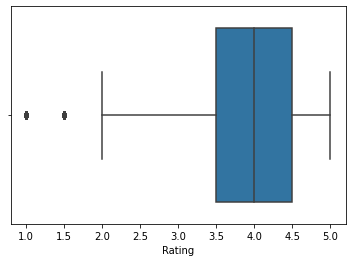

In [55]:
sns.boxplot(x=df['Rating'])

Распределение выглядит смещённым в сторону более высоких оценок, с некоторыми выбросами.

Посмотрим на рейтинг заведений в разбивке по городам.

<AxesSubplot:xlabel='Rating', ylabel='City'>

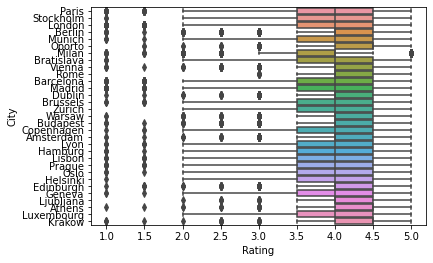

In [56]:
sns.boxplot(x=df['Rating'], y=df['City'])

По всем городам есть выбросы, относящиеся к низким показателям рейтинга, и только в Милане оценка 5.0 тоже относится к выбросам.

<AxesSubplot:xlabel='Rating', ylabel='Features'>

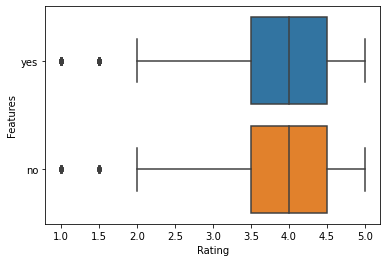

In [57]:
sns.boxplot(x=df['Rating'], y=df['Features'])

В зависимости от показателя Features результат Rating не меняется. Уберём его из датасета.

<AxesSubplot:xlabel='Rating', ylabel='Meals'>

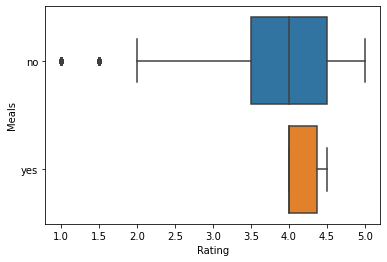

In [58]:
sns.boxplot(x=df['Rating'], y=df['Meals'])

А от показателя Meals - меняется. Оставим его в итоговом датасете.

In [62]:
df['Price Range'] = df['Price Range'].replace('$ ', '$')

<AxesSubplot:xlabel='Rating', ylabel='Ranking'>

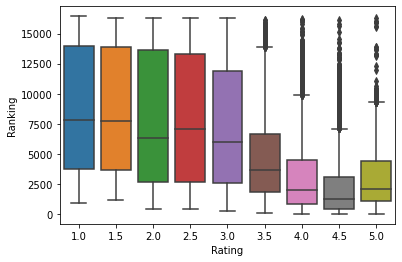

In [81]:
sns.boxplot(x=df['Rating'], y=df['Ranking'])

Что интересно - чем выше оценка ресторана, тем, скорее всего, ниже его ранкинг.

<AxesSubplot:xlabel='Rating', ylabel='Number of Reviews'>

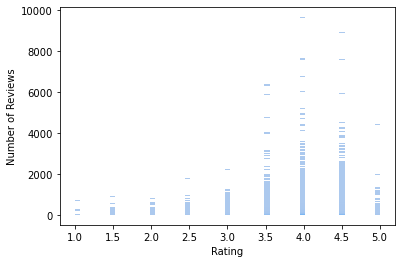

In [79]:
sns.histplot(x=df['Rating'], y=df['Number of Reviews'])

Похоже на график распределения оценки заведения.

Чем больше рецензий - тем выше средняя оценка.

In [83]:
### делаем предварительные корректировки для показателя Price Range, потому что символ '$' плохо воспринимается библиотеками
df['Price Range'] = df['Price Range'].replace('$$$$', 'Price Range 4')
df['Price Range'] = df['Price Range'].replace('$$ - $$$', 'Price Range 2-3')
df['Price Range'] = df['Price Range'].replace('$', 'Price Range 1')

<AxesSubplot:xlabel='Rating', ylabel='Price Range'>

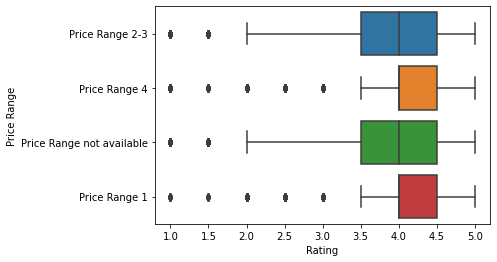

In [88]:
sns.boxplot(x=df['Rating'], y=df['Price Range'])

Показатель Price Range так же влияет на целевую переменную.

### Преобразование

Подготовим к преобразованию номинативные показатели

- City, Cuisine Style - превратим в dummy-переменные;
- Features - удалим;
- Meals - преобразуем yes в 1, no в 0;
- Price Range - преобразуем в 0 (not available) / 1 / 2 / 3 (price range 4);
- Reviews, URL_TA, URL_full - удалим.

Некоторые столбцы будем использовать в дальнейшем для слияния датасетов.

In [89]:
df_3 = df

In [163]:
df['Meals'] = df['Meals'].apply(lambda x: 1 if 'yes' else 0)

In [90]:
df = df.drop(['Features', 'Reviews', 'URL_TA', 'URL_full'], axis=1)

In [92]:
cols = [*df.columns]
cols.remove('Cuisine Style')

In [97]:
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace(',', ', '))
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace('  ', ' '))
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: str(x).split(', '))

In [116]:
df_4 = df.explode('Cuisine Style')

df_4['Cuisine Style']

In [118]:
def cuisine_clean_2(x):
    x = x.replace("'", "")
    x = x.replace('"', '')
    x = x.replace('[', '')
    x = x.replace(']', '')
    return x

In [119]:
df_4['Cuisine Style'] = df_4['Cuisine Style'].apply(lambda x: cuisine_clean_2(x))

df_4['Cuisine Style'] = df_4['Cuisine Style'].apply(lambda x: x.replace(' ', '_'))

In [126]:
styles_dummies = pd.get_dummies(df_4['Cuisine Style'])

styles_dummies = styles_dummies.groupby(by=styles_dummies.index, as_index=False).agg('sum')

df = pd.merge(df, styles_dummies, how='right', on=df.index)
df = df.drop(['Cuisine Style', 'key_0'], axis=1)

In [134]:
cols = [*df.columns]
cols.remove('City')

city_dummies = pd.get_dummies(df_3['City'])

city_dummies = city_dummies.groupby(by=city_dummies.index, as_index=False).agg('sum')

df = pd.merge(df, city_dummies, how='right', on=df.index)
df = df.drop(['City', 'key_0'], axis=1)

In [136]:
range_dict = {'Price Range 1':1, 'Price Range 2-3':2, 'Price Range 4':3, 'Price Range not available':0}

df['Price Range'] = df['Price Range'].apply(lambda x: range_dict[x])

In [138]:
df

,Ranking,Rating,Price Range,Number of Reviews,ID_TA,Meals,Afghani,African,Albanian,American,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,5570.0,3.5,2,194.0,d1912643,no,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1537.0,4.0,2,10.0,d7992032,no,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,353.0,4.5,3,688.0,d8632781,no,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3458.0,5.0,0,3.0,d1358776,no,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,621.0,4.0,2,84.0,d6864963,no,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39975,500.0,4.5,2,79.0,d2104414,no,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39976,6341.0,3.5,2,542.0,d1800036,no,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
39977,1652.0,4.5,0,4.0,d947615,no,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
39978,641.0,4.0,2,70.0,d1100838,no,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Нормализация

Посмотрим на имеющиеся данные

In [139]:
df.describe()

,Ranking,Rating,Price Range,Number of Reviews,Afghani,African,Albanian,American,Arabic,Argentinean,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
count,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,...,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.00000,39980.000000,39980.000000,39980.000000
mean,3676.497249,3.992909,1.506978,116.890145,0.000575,0.004402,0.000200,0.036218,0.001426,0.004427,...,0.022336,0.012831,0.009630,0.122486,0.036093,0.051976,0.02051,0.029165,0.018184,0.013457
std,3709.500590,0.668471,0.912531,287.785867,0.023979,0.066204,0.014144,0.186835,0.037732,0.066391,...,0.147776,0.112548,0.097659,0.327851,0.186524,0.221981,0.14174,0.168270,0.133618,0.115221
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,973.000000,3.500000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2284.000000,4.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,5261.000000,4.500000,2.000000,104.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,16444.000000,5.000000,3.000000,9660.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


Практически все показатели имеют похожий мастштаб. Исключение - Ranking и Number of Reviews.

Приведём их к похожему масштабу - минимум=0, максимум=1

In [150]:
df_5 = df.copy()

In [141]:
from sklearn import preprocessing

In [142]:
min_max_scaler = preprocessing.MinMaxScaler()

df[['Ranking', 'Number of Reviews']] = min_max_scaler.fit_transform(df[['Ranking', 'Number of Reviews']])

In [153]:
df.describe()

,Ranking,Rating,Price Range,Number of Reviews,Afghani,African,Albanian,American,Arabic,Argentinean,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
count,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,...,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.00000,39980.000000,39980.000000,39980.000000
mean,0.223530,3.992909,1.506978,0.012100,0.000575,0.004402,0.000200,0.036218,0.001426,0.004427,...,0.022336,0.012831,0.009630,0.122486,0.036093,0.051976,0.02051,0.029165,0.018184,0.013457
std,0.225598,0.668471,0.912531,0.029791,0.023979,0.066204,0.014144,0.186835,0.037732,0.066391,...,0.147776,0.112548,0.097659,0.327851,0.186524,0.221981,0.14174,0.168270,0.133618,0.115221
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.059113,3.500000,1.000000,0.000725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.138843,4.000000,2.000000,0.002899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.319893,4.500000,2.000000,0.010792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


## Собираем функцию для предобработки датасета kaggle task

In [178]:
def preprocessing(dataset):
    print('Creating URLs')
    dataset['URL_full'] = dataset['URL_TA'].apply(lambda x: str('https://www.tripadvisor.com'+x))
    print('Creating new columns')
    dataset = pd.concat([dataset,pd.DataFrame(columns=['Features', 'Meals'])])
    print('Start scraping')
    for i in dataset.index:
        print('Scraping index', i)
        dataset.iloc[i] = scraping(dataset.iloc[i])
    print('Filling missing values')    
    dataset['Number of Reviews'] = dataset['Number of Reviews'].fillna(0)
    dataset['Cuisine Style'] = dataset['Cuisine Style'].fillna('Cuisine Style not available')
    dataset['Price Range'] = dataset['Price Range'].fillna('Price Range not available')
    dataset['Meals'] = dataset['Meals'].apply(lambda x: 1 if 'yes' else 0)
    dataset = dataset.drop(['Features', 'Reviews', 'URL_TA', 'URL_full'], axis=1)
    print('Getting dummies out of Cuisine Style feature')
    cols = [*dataset.columns]
    cols.remove('Cuisine Style')
    dataset['Cuisine Style'] = dataset['Cuisine Style'].apply(lambda x: x.replace(',', ', '))
    dataset['Cuisine Style'] = dataset['Cuisine Style'].apply(lambda x: x.replace('  ', ' '))
    dataset['Cuisine Style'] = dataset['Cuisine Style'].apply(lambda x: str(x).split(', '))
    dataset_2 = dataset.explode('Cuisine Style')
    dataset_2['Cuisine Style'] = dataset_2['Cuisine Style'].apply(lambda x: cuisine_clean_2(x))
    dataset_2['Cuisine Style'] = dataset_2['Cuisine Style'].apply(lambda x: x.replace(' ', '_'))
    styles_dummies = pd.get_dummies(dataset_2['Cuisine Style'])
    styles_dummies = styles_dummies.groupby(by=styles_dummies.index, as_index=False).agg('sum')
    dataset = pd.merge(dataset, styles_dummies, how='right', on=dataset.index)
    dataset = dataset.drop(['Cuisine Style', 'key_0'], axis=1)
    print('Getting dummies out of City feature')
    cols = [*dataset.columns]
    cols.remove('City')
    city_dummies = pd.get_dummies(dataset['City'])
    city_dummies = city_dummies.groupby(by=city_dummies.index, as_index=False).agg('sum')
    dataset = pd.merge(dataset, city_dummies, how='right', on=dataset.index)
    dataset = dataset.drop(['City', 'key_0'], axis=1)  
    print('Fixing price range')
    range_dict = {'$':1, '$ ':1, '$$ - $$$':2, '$$$$':3, 'Price Range not available':0}
    dataset['Price Range'] = dataset['Price Range'].apply(lambda x: range_dict[x])
    print('Done!')
    return dataset

In [170]:
kaggle = pd.read_csv('kaggle_task.csv')

In [175]:
kaggle

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,URL_full
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,https://www.tripadvisor.com/Restaurant_Review-...
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,https://www.tripadvisor.com/Restaurant_Review-...
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,https://www.tripadvisor.com/Restaurant_Review-...
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,https://www.tripadvisor.com/Restaurant_Review-...
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,https://www.tripadvisor.com/Restaurant_Review-...
...,...,...,...,...,...,...,...,...,...,...
9995,id_9995,London,"['Caribbean', 'Barbecue', 'Jamaican', 'Vegetar...",4367.0,$,28.0,[['By far best Chicken burgers and wings in L....,/Restaurant_Review-g186338-d11916827-Reviews-C...,d11916827,https://www.tripadvisor.com/Restaurant_Review-...
9996,id_9996,Lisbon,"['Indian', 'Asian', 'Nepali', 'Bangladeshi']",2612.0,$$ - $$$,2.0,"[['Ok indian food'], ['11/25/2017']]",/Restaurant_Review-g189158-d12701633-Reviews-C...,d12701633,https://www.tripadvisor.com/Restaurant_Review-...
9997,id_9997,Milan,NaN,5562.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d13198194-Reviews-Q...,d13198194,https://www.tripadvisor.com/Restaurant_Review-...
9998,id_9998,Milan,['Italian'],4010.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d3862815-Reviews-La...,d3862815,https://www.tripadvisor.com/Restaurant_Review-...


In [ ]:
kaggle = preprocessing(kaggle)

In [180]:
kaggle

,Restaurant_id,Ranking,Price Range,Number of Reviews,ID_TA,Meals,Afghani,African,American,Arabic,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,id_0,12963.0,2,4.0,d10746918,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,106.0,2,97.0,d6674944,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,810.0,2,28.0,d13129638,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,1669.0,3,202.0,d680417,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,37.0,3,162.0,d1112354,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,id_9995,4367.0,1,28.0,d11916827,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,id_9996,2612.0,2,2.0,d12701633,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,id_9997,5562.0,2,2.0,d13198194,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,id_9998,4010.0,0,2.0,d3862815,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
### проверяем отличающиеся колонки
diff_cols = df.columns.difference(kaggle.columns)
diff_cols

Index(['Albanian', 'Burmese', 'Cajun_Creole', 'Catalan', 'Caucasian',
       'Emilian', 'Fruit_parlours', 'Fujian', 'Latvian', 'Lombard',
       'Northern_Italian', 'Polynesian', 'Rating', 'Romagna', 'Salvadoran',
       'Uzbek', 'Xinjiang'],
      dtype='object')

In [185]:
df_copy = df.copy()
kaggle_copy = kaggle.copy()

In [186]:
for item in diff_cols:
    if item != 'Rating':
        if item in df.columns:
            kaggle[item] = 0
        else:
            df[item] = 0
    else:
        continue           

In [227]:
kaggle.columns.difference(df.columns)

Index(['Restaurant_id', 'Sardinian'], dtype='object')

In [228]:
df['Sardinian'] = 0

In [190]:
df.describe()

,Ranking,Rating,Price Range,Number of Reviews,Meals,Afghani,African,Albanian,American,Arabic,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
count,39980.000000,39980.000000,39980.000000,39980.000000,39980.0,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,...,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.000000,39980.00000,39980.000000,39980.000000,39980.000000
mean,0.223530,3.992909,1.506978,0.012100,1.0,0.000575,0.004402,0.000200,0.036218,0.001426,...,0.022336,0.012831,0.009630,0.122486,0.036093,0.051976,0.02051,0.029165,0.018184,0.013457
std,0.225598,0.668471,0.912531,0.029791,0.0,0.023979,0.066204,0.014144,0.186835,0.037732,...,0.147776,0.112548,0.097659,0.327851,0.186524,0.221981,0.14174,0.168270,0.133618,0.115221
min,0.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.059113,3.500000,1.000000,0.000725,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.138843,4.000000,2.000000,0.002899,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.319893,4.500000,2.000000,0.010792,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,5.000000,3.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [191]:
kaggle.describe()

,Ranking,Price Range,Number of Reviews,Meals,Afghani,African,American,Arabic,Argentinean,Armenian,...,Fruit_parlours,Fujian,Latvian,Lombard,Northern_Italian,Polynesian,Romagna,Salvadoran,Uzbek,Xinjiang
count,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,3618.023500,1.516200,114.966400,1.0,0.000500,0.004200,0.035300,0.000900,0.004800,0.000300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,3665.076451,0.913795,279.868521,0.0,0.022356,0.064674,0.184546,0.029988,0.069119,0.017319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,966.000000,1.000000,7.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2257.000000,2.000000,27.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,5137.000000,2.000000,105.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,16443.000000,3.000000,6437.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
#нормализация
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

kaggle[['Ranking', 'Number of Reviews']] = min_max_scaler.fit_transform(kaggle[['Ranking', 'Number of Reviews']])

In [195]:
kaggle.describe()

,Ranking,Price Range,Number of Reviews,Meals,Afghani,African,American,Arabic,Argentinean,Armenian,...,Fruit_parlours,Fujian,Latvian,Lombard,Northern_Italian,Polynesian,Romagna,Salvadoran,Uzbek,Xinjiang
count,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.219939,1.516200,0.017860,1.0,0.000500,0.004200,0.035300,0.000900,0.004800,0.000300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.222923,0.913795,0.043478,0.0,0.022356,0.064674,0.184546,0.029988,0.069119,0.017319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.058634,1.000000,0.001087,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.137157,2.000000,0.004195,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.312329,2.000000,0.016312,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,3.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [313]:
X = df.drop(['ID_TA', 'Rating'], axis = 1)
y = df['Rating']

In [314]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [315]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 20% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Создаём, обучаем и тестируем модель

In [316]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [317]:
#проверим результат y_pred
y_pred

array([4.35 , 3.765, 4.035, ..., 4.075, 4.465, 4.135])

In [318]:
#результат отличается от способа занесения данных в датасете. нужно округление до ближайшего шага 0.5
y_pred_round = np.round(y_pred / 0.5) * 0.5
y_pred_round

array([4.5, 4. , 4. , ..., 4. , 4.5, 4. ])

In [319]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20916270635317658


In [321]:
# Сделаем проверку MAE для нового показателя
print('MAE rounded:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE rounded: 0.18359179589794897


Поскольку результат с округлением лучше, применим округление и для сабмишна.

### Запускаем модель для участия в соревновании

In [323]:
y_kaggle = kaggle.drop(['Restaurant_id', 'ID_TA'], axis=1)

In [324]:
kaggle_pred = regr.predict(y_kaggle)

In [325]:
kaggle_result = np.round(kaggle_pred / 0.5) * 0.5
kaggle_result

array([3.5, 4.5, 4. , ..., 1. , 2. , 3.5])

In [326]:
kaggle_result_df = pd.DataFrame({'Restaurant_id':0, 'Rating':kaggle_result})

kaggle_result_df['Restaurant_id'] = kaggle_result_df.index
kaggle_result_df['Restaurant_id'] = kaggle_result_df['Restaurant_id'].apply(lambda x: 'id_'+str(x))

In [327]:
kaggle_result_df.to_csv('kaggle_submission.csv', index=False)